In [22]:
# Import libaraies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Step 1: Preprocess Data

In [28]:
# nltk.download('punkt_tab')
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

### 1.1 Drop unrelated columns and NA/None values

In [29]:
def clean_data(folder='data',files = ['Automotive_5.json','CDs_and_Vinyl_5.json','Cell_Phones_and_Accessories_5.json','Grocery_and_Gourmet_Food_5.json','Toys_and_Games_5.json']):
    
    review_files = {}
    
    for file_name in files:
        name = file_name.split('_')[0]
        row  = pd.read_json(folder+'/'+file_name,lines=True)
        # Delete all columns except 'Ooverall', 'reviewText', 'summary'
        row = row.drop(columns=['verified','reviewTime','reviewerID','asin','reviewerName','unixReviewTime','vote','image','style'])
        print(f"For category {name}")
        print(row.isnull().sum())
        print(f"Dataset before dropping: {len(row)}")
        # Delet all null rows
        row = row.dropna()
        print(f"Dataset after dropping: {len(row)}")
        row['reviewText'] = row['reviewText']
        review_files[name] = row
    
    return review_files

In [54]:
df_collect = clean_data()

For category Automotive
overall         0
reviewText    866
summary       342
dtype: int64
Dataset before dropping: 1711519
Dataset after dropping: 1710350
For category CDs
reviewText    280
overall         0
summary       227
dtype: int64
Dataset before dropping: 1443755
Dataset after dropping: 1443288
For category Cell
overall         0
reviewText    765
summary       517
dtype: int64
Dataset before dropping: 1128437
Dataset after dropping: 1127206
For category Grocery
overall         0
reviewText    390
summary       219
dtype: int64
Dataset before dropping: 1143860
Dataset after dropping: 1143292
For category Toys
overall          0
reviewText    1175
summary        372
dtype: int64
Dataset before dropping: 1828971
Dataset after dropping: 1827456


In [ ]:
""""
def read_file(filepath):
    seg_docs = {}
    
    with open(filepath, 'r') as file:
        file_dict = json.load(file)
    
    seg_docs = {}
    
    for key, text in file_dict.items():
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = word_tokenize(text)
        words_list = []
        for word in words:
            if word not in stop_words:
                words_list.append(word)
        
        seg_docs[key] = words_list
    
    return seg_docs
    """

In [ ]:
"""
def strip_clean(reviews_dict):
    
    def process_entry(sentence):
        sentence = sentence.lower()
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        words_list = []
        for word in sentence:
            if word not in stop_words():
                words_list.append(word)
        return words_list
    
    stripped_dict = {}
    
    for key,df in reviews_dict.items():
        df['reviewText'] = df['reviewText'].apply(process_entry)
        df['summary'] = df['summary'].apply(process_entry)
        stripped_dict[key] = df
    
    return stripped_dict
    """

In [ ]:
# df_reduced_list = strip_clean(df_collect)

In [ ]:
df_reduced_list['Automotive']

In [55]:
print(df_collect.keys())

dict_keys(['Automotive', 'CDs', 'Cell', 'Grocery', 'Toys'])


### 1.2 Drop duplcates

In [56]:
def drop_duplicate(tables):
    # Initialize a dictionary to store data
    clean_tables = {}
    for name, table in tables.items():
        print(f"For category {name}")
        
        # Convert the table into dataframe
        df = pd.DataFrame(table)
        duplicates = df.duplicated()
        print(f"Number of duplicate: {duplicates.sum()}")

        print(f"Before dropping: {len(df)}")
        df_clean = df.drop_duplicates()
        print(f"After dropping: {len(df_clean)}")

        # Store the cleaned data into dictionary
        clean_tables[name] = df_clean
    return clean_tables

In [57]:
clean_tables = drop_duplicate(df_collect)

For category Automotive
Number of duplicate: 322354
Before dropping: 1710350
After dropping: 1387996
For category CDs
Number of duplicate: 191204
Before dropping: 1443288
After dropping: 1252084
For category Cell
Number of duplicate: 171530
Before dropping: 1127206
After dropping: 955676
For category Grocery
Number of duplicate: 230906
Before dropping: 1143292
After dropping: 912386
For category Toys
Number of duplicate: 326697
Before dropping: 1827456
After dropping: 1500759


### 1.3 Statistical analysis

After preprocessing, we need some statistical analysis. 

In [58]:
print(clean_tables.keys())

dict_keys(['Automotive', 'CDs', 'Cell', 'Grocery', 'Toys'])


In [59]:
def pie_chart_statistic(tables):
    for name, table in tables.items():
        if 'overall' in table:
            # Convert to series and count the 'overall ratings'
            counts = pd.Series(table['overall']).value_counts()
            print(f"Number of ratings of {name}: {counts}")

            # Draw the pie charts
            plt.figure(figsize = (6,6))
            plt.pie(
                counts,
                labels = counts.index,
                autopct = '%1.1f%%',
                startangle = 90,
                wedgeprops = {'edgecolor': 'black'}
            )

            plt.title(f"Distribution of Ratings in {name}")
            plt.show()
        
        else:
            print(f"No 'overall' column found in {name}")

Number of ratings of Automotive: overall
5    971580
4    202218
3     91867
1     74017
2     48314
Name: count, dtype: int64


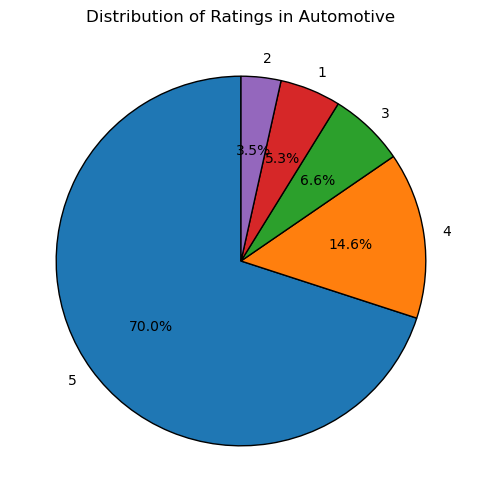

Number of ratings of CDs: overall
5    813811
4    250756
3    102760
2     43769
1     40988
Name: count, dtype: int64


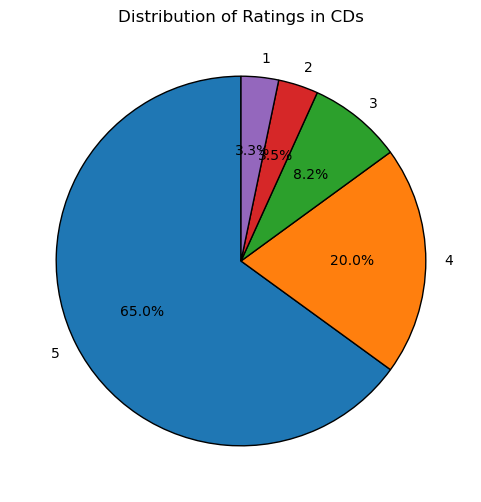

Number of ratings of Cell: overall
5    569477
4    163280
3     90656
1     77448
2     54815
Name: count, dtype: int64


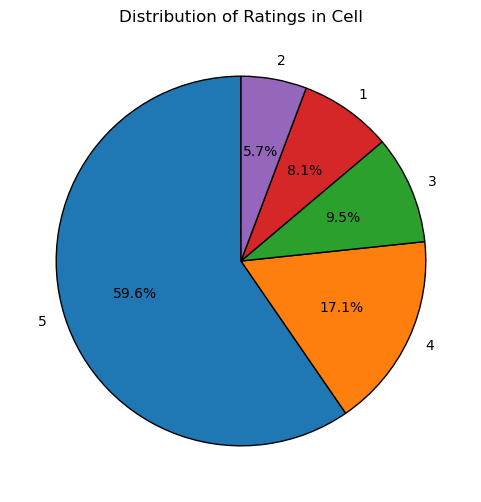

Number of ratings of Grocery: overall
5    637248
4    124386
3     69986
1     43417
2     37349
Name: count, dtype: int64


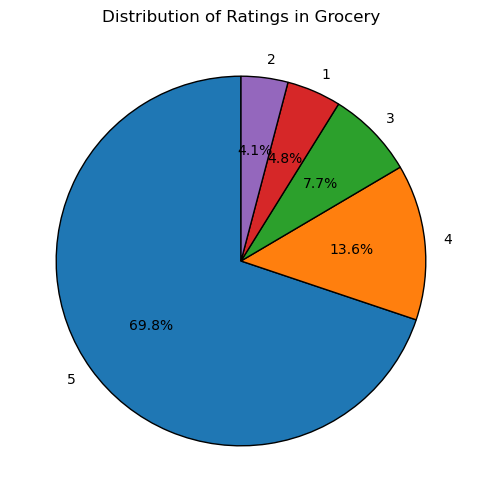

Number of ratings of Toys: overall
5    1025714
4     241122
3     120025
1      59163
2      54735
Name: count, dtype: int64


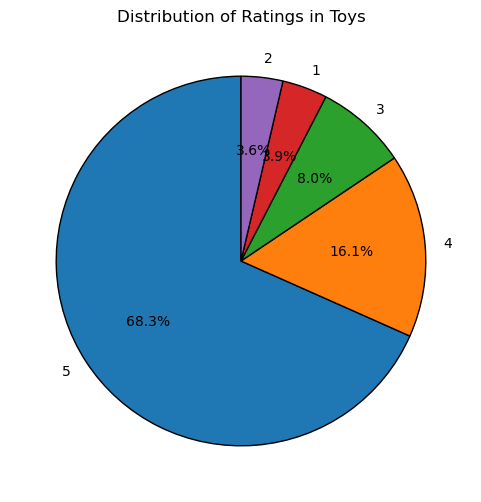

In [60]:
pie_chart_statistic(clean_tables)

### 1.4 Split 5 data frames based on category

In [ ]:
def create_category_dataframes(tables):
    for category, data in tables.items():
       globals()[f"df_{category}"] = pd.DataFrame(data)


# For each category, create a dataframe
create_category_dataframes(clean_tables)
df_CDs.head()

,reviewText,overall,summary
0,Love it!! Great seller!,5,Five Stars
1,One of my very favourite albums from one of my...,5,One of my very favourite albums from one of my...
2,"THank you Jesus Lord God, that brother Green's...",5,Five Stars
3,I recall loving his other albums and maybe thi...,5,forgot but I figured on some of these artists ...
4,Keith Green was a pioneer in the field of Chri...,5,and I have loved every album he did


## Step 3: Vectorization

In [7]:
# Do we need to set stopwords or lowercase here?
def preprocess_text(text):
    stop_words = set(stop_words('english'))
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = text.split()
    

In [11]:
def transform_text_into_tfidf_vector(df, summary = False):
    X = None
    y = None
    vectorizer = None

    # Identify y
    y = df['overall'].values

    # Select column for vectorization
    if summary:
        text_column = 'summary'
    else:
        text_column = 'reviewText'

    texts = df[text_column]

    # Set parameter for vectorizer
    vectorizer = TfidfVectorizer(max_features=10000, stop_words = 'english')

    X = vectorizer.fit_transform(texts)

    return X, y, vectorizer

In [13]:
# Take CD category as an example
X_CDs, y_CDs, vectorizer = transform_text_into_tfidf_vector(df_CDs, summary = False)
print(X_CDs)

  (0, 5379)	0.3465869513476443
  (0, 4016)	0.2917767413134023
  (0, 7888)	0.8914840539146383
  (1, 3430)	0.5833081557555778
  (1, 430)	0.1505879479717377
  (1, 8123)	0.24838376170127396
  (1, 4150)	0.23057327664186195
  (1, 7363)	0.33771970481217106
  (1, 6226)	0.18254048705285422
  (1, 9908)	0.34715233438322407
  (1, 1480)	0.4203730621270011
  (1, 9957)	0.15964743849167642
  (1, 389)	0.22830932678676846
  (2, 8991)	0.3224535425386348
  (2, 4841)	0.39639286430299425
  (2, 5351)	0.4042489313847334
  (2, 3937)	0.30791493000555037
  (2, 1275)	0.38032973453896507
  (2, 4025)	0.373770311992832
  (2, 5954)	0.14144795336897448
  (2, 8338)	0.2967377746365364
  (2, 4351)	0.2970720853222618
  (3, 430)	0.22111395275888115
  (3, 5954)	0.0802114369141391
  (3, 7178)	0.4825528841196097
  :	:
  (1443283, 1147)	0.20217417439912813
  (1443283, 2331)	0.22973900766031322
  (1443284, 6222)	1.0
  (1443285, 5379)	0.25687859544167635
  (1443285, 4016)	0.43251022117076926
  (1443285, 5954)	0.4450384094192425


In [14]:
# Split train and test set
def training_testing_split(X, y, test_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

    return (X_train, X_test, y_train, y_test)

In [ ]:
X_train_CDs, X_test_CDs, y_train_CDs, y_test_CDs = training_testing_split(X_CDs, y_CDs, test_size = 0.8)

## Step 4: Models Training

In [24]:
classifier1 = RandomForestClassifier(class_weight='balanced')

classifier1.fit(X_train_CDs, y_train_CDs)
y_pred_CDs = classifier1.predict(X_test_CDs)

accuracy1 = accuracy_score(y_test_CDs, y_pred_CDs)

In [25]:
accuracy1

0.6781188102519333